<a href="https://colab.research.google.com/github/Emtiaz-pro/CVPR/blob/main/MID/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Starting webcam... Please allow camera access when prompted.


<IPython.core.display.Javascript object>

Predicted digit: 1 with confidence: 99.02%


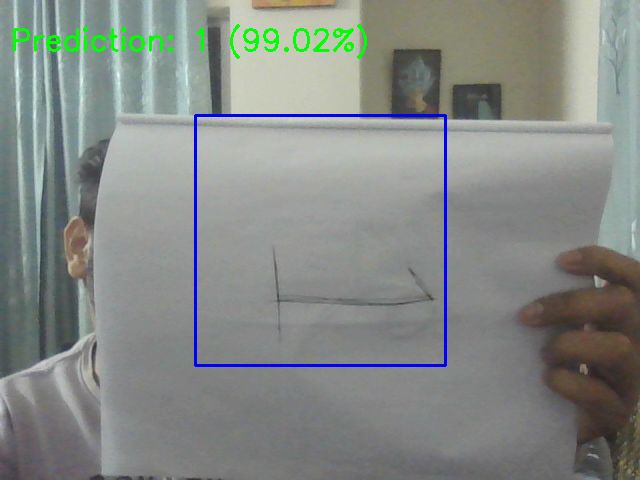

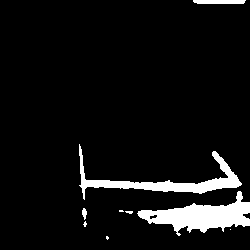

Webcam stopped


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import io
import PIL.Image
import time

model = tf.keras.models.load_model('/content/drive/MyDrive/mnist_model.h5')


def predict_digit(img):
    img = cv2.resize(img, (28, 28))
    img = img.reshape(1, 28, 28, 1)
    img = img.astype("float32") / 255.0
    pred = model.predict(img, verbose=0)
    return np.argmax(pred), np.max(pred)

def create_webcam_video():
    js = Javascript('''
    async function createWebcam() {
        const video = document.createElement('video');
        video.style.width = '640px';
        video.style.height = '480px';
        video.setAttribute('playsinline', '');
        video.setAttribute('autoplay', '');

        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;

        const container = document.createElement('div');
        container.appendChild(video);
        document.body.appendChild(container);

        // Create capture button
        const captureBtn = document.createElement('button');
        captureBtn.textContent = 'Capture and Predict';
        captureBtn.style.margin = '10px';
        document.body.appendChild(captureBtn);

        // Create quit button
        const quitBtn = document.createElement('button');
        quitBtn.textContent = 'Quit';
        quitBtn.style.margin = '10px';
        document.body.appendChild(quitBtn);

        await new Promise((resolve) => {
            video.onloadedmetadata = () => {
                resolve();
            };
        });

        video.play();

        return new Promise((resolve) => {
            captureBtn.onclick = () => {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                const data = canvas.toDataURL('image/jpeg', 0.8);
                resolve(data);
            };

            quitBtn.onclick = () => {
                stream.getTracks().forEach(track => track.stop());
                container.remove();
                captureBtn.remove();
                quitBtn.remove();
                resolve(null);
            };
        });
    }
    ''')
    display(js)

def data_url_to_cv2_img(data_url):
    data = data_url.split(',')[1]
    binary = b64decode(data)

    img = PIL.Image.open(io.BytesIO(binary))
    img = np.array(img)
    img = img[:, :, ::-1].copy()

    return img

def main():
    print("Starting webcam... Please allow camera access when prompted.")
    create_webcam_video()

    while True:
        data_url = eval_js('createWebcam()')

        if data_url is None:
            print("Webcam stopped")
            break
        frame = data_url_to_cv2_img(data_url)

        h, w, _ = frame.shape

        box_size = 250
        x1 = w // 2 - box_size // 2
        y1 = h // 2 - box_size // 2
        x2 = w // 2 + box_size // 2
        y2 = h // 2 + box_size // 2


        frame_with_rect = frame.copy()
        cv2.rectangle(frame_with_rect, (x1, y1), (x2, y2), (255, 0, 0), 2)

        roi = frame[y1:y2, x1:x2]


        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thres = cv2.threshold(blur, 128, 255, cv2.THRESH_BINARY_INV)

        digit, acc = predict_digit(thres)

        cv2.putText(frame_with_rect, f"Prediction: {digit} ({acc*100:.2f}%)",
                    (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2)


        print(f"Predicted digit: {digit} with confidence: {acc*100:.2f}%")
        cv2_imshow(frame_with_rect)
        cv2_imshow(thres)

        time.sleep(1)

if __name__ == "__main__":
    main()